In this notebook, we calculate the number of trajectories that beach and don't beach, the percent of drifters that beach within a year, and generate histograms of undrogued time to beach and trajectory lengths.

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters')

In [91]:
# dependencies
import numpy as np
import pandas as pd

from geopy.distance import geodesic

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set plotting text size parameters
plt.rcParams.update({
    'axes.titlesize': 30,
    'axes.labelsize': 24, 
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 18, 
    'figure.titlesize': 28})

In [4]:
# load drifter data
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

In [22]:
print(f"number of undrogued beaching trajectories: {len(beach_undrogued.drop_duplicates(subset='id', keep='last'))}")
print(f"number of undrogued nonbeaching trajectories: {len(unbeach_undrogued.drop_duplicates(subset='id', keep='last'))}")

number of undrogued beaching trajectories: 4252
number of undrogued nonbeaching trajectories: 11803


In [66]:
unique_drift=beach_undrogued.drop_duplicates(subset='id',keep='first')

df_sorted = unique_drift.sort_values(by='time_to_beach')

# Calculate the cumulative count and the percentage
df_sorted['cumulative_count'] = range(1, len(df_sorted) + 1)
total_count = df_sorted['cumulative_count'].iloc[-1]
df_sorted['cumulative_percentage'] = df_sorted['cumulative_count'] / total_count * 100

# Find the largest 'time_to_beach' where the cumulative percentage is more than 75%
most_time = df_sorted[df_sorted['cumulative_percentage'] >= 75]['time_to_beach'].iloc[0]

print(f"75% of beaching drifters beach within {round(most_time / 60/ 60 /24 /30,1)} months of losing their drogue.")

# including all drifters
total_count = total_count + len(unbeach_undrogued.drop_duplicates(subset='id', keep='last'))
df_sorted['cumulative_percentage'] = df_sorted['cumulative_count'] / total_count * 100
most_time = df_sorted[df_sorted['cumulative_percentage'] >= 20]['time_to_beach'].iloc[0]

print(f"20% of all drifters beach within {round(most_time / 60/ 60 /24 /30,1)} months of losing their drogue.")

75% of beaching drifters beach within 11.6 months of losing their drogue.
20% of all drifters beach within 11.9 months of losing their drogue.


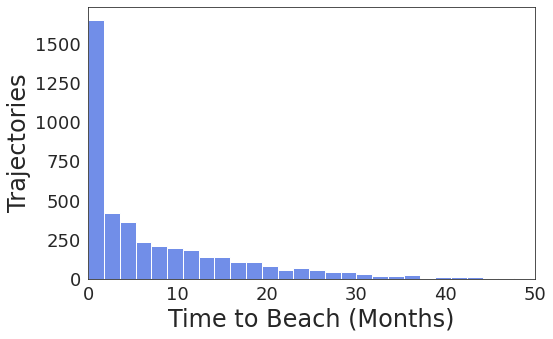

In [181]:
# histogram of time to beach by trajectory
plt.figure(figsize=(8, 5))
sns.histplot(round(unique_drift['time_to_beach'] / 60/ 60 /24 /30,1), bins=40, color="royalblue")

plt.xlim(0,50)
plt.xlabel("Time to Beach (Months)")
plt.ylabel("Trajectories")

plt.show()

In [164]:
# calculate trajectory lengths, where net travel is the distance from the starting
# location to the final location, and gross travel is the sum of distances between 
# each point making up the the trajectory (hourly).
# first we define the haversine function to calculate great circle distances:
def haversine(lat1, lon1, lat2, lon2):
    earth_radius = 6378
    
    # convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1,lon1,lat2,lon2])
   
    # calculate differences
    dif_lat = lat2 - lat1
    dif_lon = lon2 - lon1
    
    # compute haversine distance
    distance_representation = np.sin(dif_lat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dif_lon / 2.0) ** 2
    angular_distance = 2 * np.arctan2(np.sqrt(distance_representation), np.sqrt(1 - distance_representation))
    
    return earth_radius * angular_distance

def calc_traj_lengths(dataframe):
    outputs = []
    # by trajectory group:
    for trajectory_id, group in dataframe.groupby('id'):
        
        # calculate arrays for lat and lon
        lat, lon = group['lat'].values, group['lon'].values
        
        # calculate net distance with first and last coordinates
        net_distance = haversine(lat[0], lon[0], lat[-1], lon[-1])
        
        # sum the distances moved hourly
        gross_distance = np.sum(haversine(lat[:-1], lon[:-1], lat[1:], lon[1:]))
        
        outputs.append(({'id':trajectory_id,'net_distance': net_distance, 'gross_distance': gross_distance}))
    return pd.DataFrame(outputs)     

In [165]:
beach_undrogued_distances = calc_traj_lengths(beach_undrogued)
unbeach_undrogued_distances = calc_traj_lengths(unbeach_undrogued)

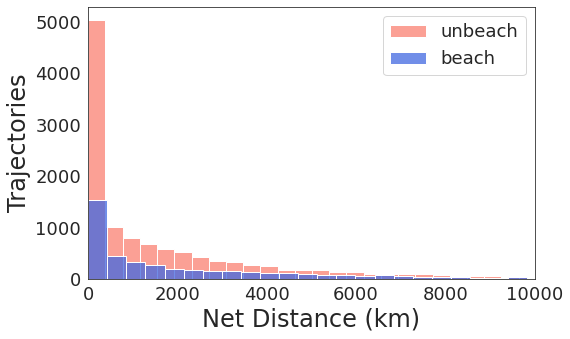

In [196]:
# histogram of net trajectory lengths
plt.figure(figsize=(8, 5))

# unbeach
sns.histplot(round(unbeach_undrogued_distances['net_distance'],1), bins=40, color="salmon", label = 'unbeach')

# beach
sns.histplot(round(beach_undrogued_distances['net_distance'],1), bins=40, color="royalblue", label = 'beach')

plt.xlim(0,10000)
plt.xlabel("Net Distance (km)")
plt.ylabel("Trajectories")
plt.legend(loc = 'upper right')

plt.show()

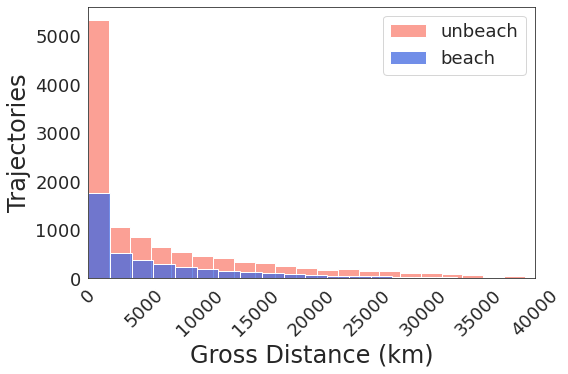

In [195]:
# histogram of gross trajectory lengths
plt.figure(figsize=(8, 5))

# unbeach
sns.histplot(round(unbeach_undrogued_distances['gross_distance'],1), bins=40, color="salmon", label = 'unbeach')

# beach
sns.histplot(round(beach_undrogued_distances['gross_distance'],1), bins=40, color="royalblue", label = 'beach')

plt.xlim(0,40000)
plt.xlabel("Gross Distance (km)")
plt.ylabel("Trajectories")
plt.legend(loc = 'upper right')

plt.xticks(rotation=45)

plt.show()